# Практическая часть

На данном этапе проекта мы оцениваем влияние показателя долговой нагрузки на риски, сопряжённые с выдачей займов. Для решения данной задачи мы обратились к методам статистического и эконометрического анализа, в том числе, построение регрессионных моделей, проведение кластерного анализа. В нашем случае, реализация поставленной цели производится посредством языка программирования "Python" и соответствующих статистических библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro

В рамках нашей работы мы используем дата-сет, содержащий в себе следующие переменные:

1. ID loan - уникальный идентификатор займа.
 
2. ID client - уникальный идентификатор клиента.

3. LoanSum - сумма займа, которую выдали клиенту.

4. LoanTerm - срок займа в днях, выбранный клиентом

5. pdn - Показатель долговой нагрузки - соотношение среднемесячных платежей заемщика по всем кредитным обязательствам, в том числе по тому, который только планируется к выдаче, к среднемесячному доходу

    6-9. Рисковые метрики

10. old_user - булева переменная, которая показывает,является ли займ первичным или повторным.

In [2]:
df = pd.read_excel('pdn_hse_with_flags.xlsx')
df.head()

,ID loan,ID client,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30,old_user
0,1,1000,6000,25,11862.10,0,0,0,0,0
1,2,1001,9900,30,70.48,0,0,0,0,1
2,3,1002,9900,30,58.60,0,0,0,0,1
3,4,1003,5000,25,679.65,1,0,1,1,0
4,5,1004,6000,20,875.48,1,1,1,1,0


Первостепенно, перед началом основной аналитической работы, мы изучили данные с точки зрения описательной статистики, наличия выбросов, вида распределения и иных характеристик.

,ID loan,ID client,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30,old_user
0,1,1000,6000,25,11862.10,0,0,0,0,0
1,2,1001,9900,30,70.48,0,0,0,0,1
2,3,1002,9900,30,58.60,0,0,0,0,1
3,4,1003,5000,25,679.65,1,0,1,1,0
4,5,1004,6000,20,875.48,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
5341,5342,6181,9900,30,295.83,1,1,1,1,1
5342,5343,6182,9900,16,384.46,1,0,1,0,1
5343,5344,6183,12000,29,680.70,1,0,1,1,1
5344,5345,6184,5000,12,249.28,0,0,0,0,0


Ниже мы просчитали ряд метрик описательной статистики, которые позволяют нам судить о характере данных, в том числе их пригодности для дальнейшего использования и необходимости работы с ними

In [3]:
df.columns.tolist()
columns = [
 'LoanSum',
 'LoanTerm',
 'pdn',
 'FPD10',
 'FPD30',
 'NPL10',
 'NPL30']

df.describe()

,ID loan,ID client,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30,old_user
count,5346.0000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000,5346.000000
mean,2673.5000,3566.494201,9275.086420,21.874486,798.740022,0.343247,0.261317,0.431725,0.352226,0.514590
std,1543.4016,1496.720257,4004.856937,7.201481,6459.111841,0.474838,0.439393,0.495363,0.477709,0.499834
min,1.0000,1000.000000,5000.000000,5.000000,5.930000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1337.2500,2262.250000,6000.000000,16.000000,119.295000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2673.5000,3554.500000,9000.000000,25.000000,253.765000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4009.7500,4857.750000,9900.000000,30.000000,562.385000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5346.0000,6185.000000,30000.000000,30.000000,406416.520000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df[columns].corr()

,LoanSum,LoanTerm,pdn,FPD10,FPD30,NPL10,NPL30
LoanSum,1.000000,0.153105,-0.050563,-0.075675,-0.068459,-0.051898,-0.050694
LoanTerm,0.153105,1.000000,-0.022620,-0.011034,-0.005715,-0.013128,-0.003136
pdn,-0.050563,-0.022620,1.000000,0.000195,0.005527,-0.000911,0.006579
FPD10,-0.075675,-0.011034,0.000195,1.000000,0.822720,0.829428,0.709045
FPD30,-0.068459,-0.005715,0.005527,0.822720,1.000000,0.682387,0.806595
NPL10,-0.051898,-0.013128,-0.000911,0.829428,0.682387,1.000000,0.846009
NPL30,-0.050694,-0.003136,0.006579,0.709045,0.806595,0.846009,1.000000


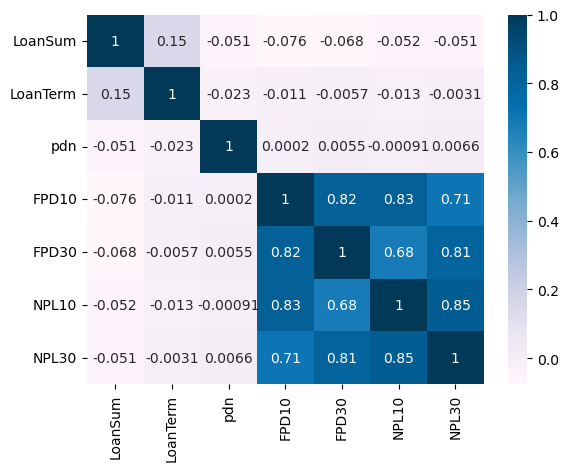

In [5]:
sns.heatmap(df[columns].corr(),cmap='PuBu', annot = True)
plt.show()

Исходя из рассчитаных нами описательной статистики и корреляционной матрицы, мы провели анализ и сделали ряд выводов, которые представлены ниже:

    В первую очередь мы рассмотрели сумму займа (переменная LoanSum в нашем дата-сете)и пришли к следующим заключениям: cредняя сумма займа составляет 9275.09 рублей, при стандартном отклонении 4004.86, что свидетельствует о значительный разбросе в размерах займов. Минимальная сумма займа - 5000, а максимальная - 30000, что позволяет судить о широком диапазоне займов, предоставляемых клиентам. Обращася к сроку займа, можно также сделать ряд выводов. Так, средний срок займа составляет примерно 22 дня, из чего можно сделать заключение о краткосрочном характере займов, что также подтверждается максимальным сроком займа, который ограничен 30 днями.

    Наибольший интерес для нас представляет показатель долговой нагрузки (pdn): В среднем данная метрика составляет 798.74, однако, мы обратили внимание на крайне неправдоподобное стандартное отклонение, которой оказалось очень велико (6459.11), что свидетельствует о большой дисперсии наблюдений и крайне вероятном наличии выбросов, что также подкрепляется максимальным значением равным в 406416.52. В последствии, при рассмотрении графиков мы обратили внимание на данную переменную и наше предположение оказалось верно.

    Значения FPD10 и FPD30 представляют собой рисковые метрики: просрочка платежа на 10 и 30 дней соответственно. Аналогично NPL10 и NPL30 являются неоплаченными займами, выданными на 10 и 30 дней соответственно. В рамках анализа описательной статистики мы не обнаружили каких-либо значимых статистических аномалий.
    Кроме того, мы также проанализировали корреляцию между переменными в целях выявления мультиколлинеарности. Так, наибольшая положительная корреляция наблюдается между рисковыми метриками, что, в рамках нашего предположения, указывает на то, что если клиент имеет просрочку на 10 дней, вероятность просрочки на 30 дней также высока. Кроме того, и все рисковые метрики достаточно сильно коррелируют между собой, что скорее всего в дальнейшем отразится в виде мультиколлинеарности.

Таким образом, мы проанализировали наши данные и сделали ряд важных выводов, кроме того, мы обнаружили ряд статистических аномалий, например, выбросов в некоторых переменных. В дальнейшем, на этапе работы с данными,мы постараемся устранить или минимизировать влияние данных проблем.

Далее мы проанализировали распределение переменных, характеризующих непрерывные величины(нет смысла рассматривать категориальные таким образом). Для этого мы построили гистограммы распределения:

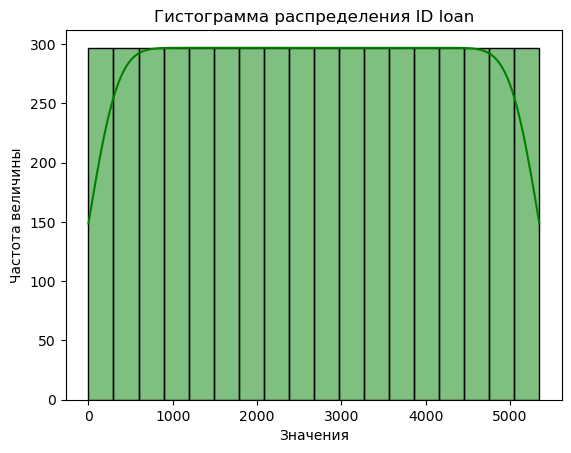

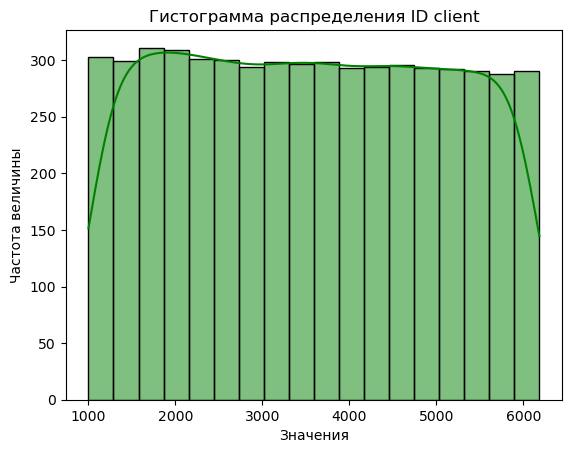

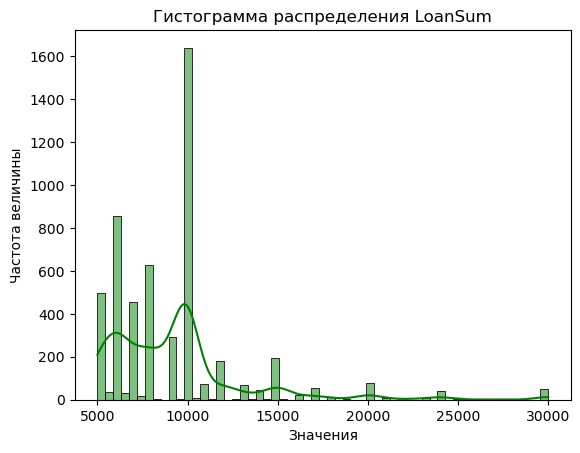

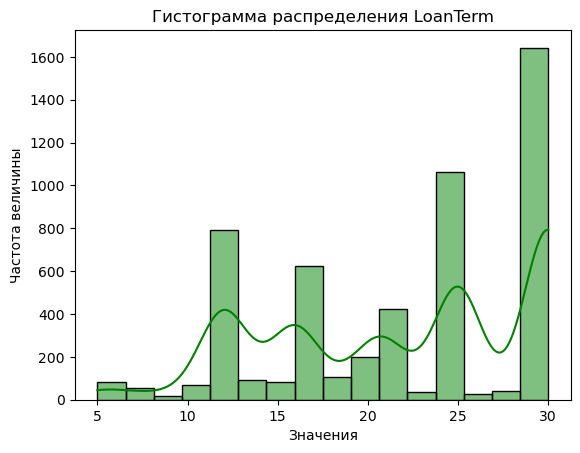

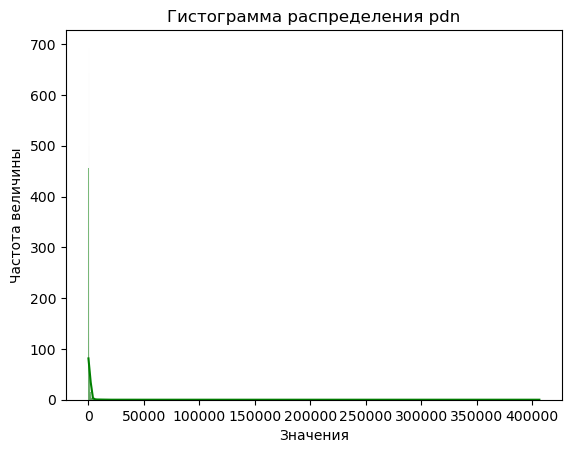

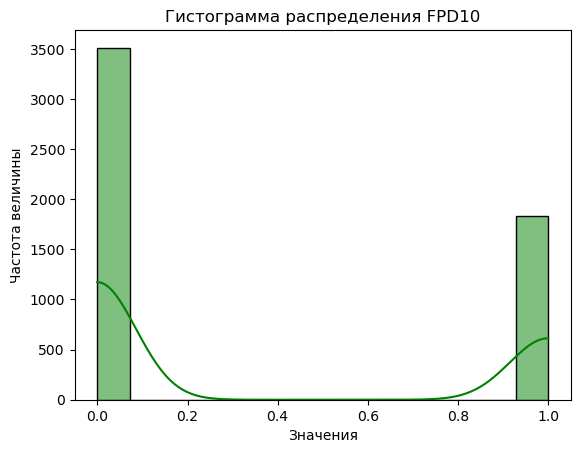

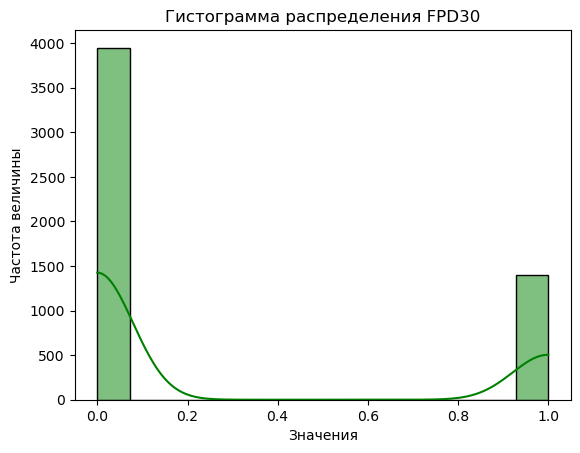

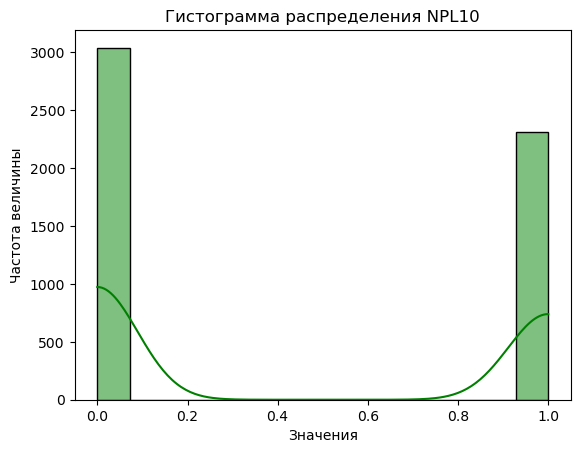

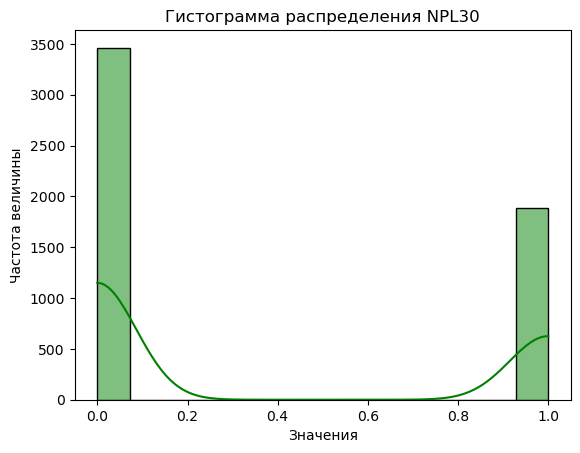

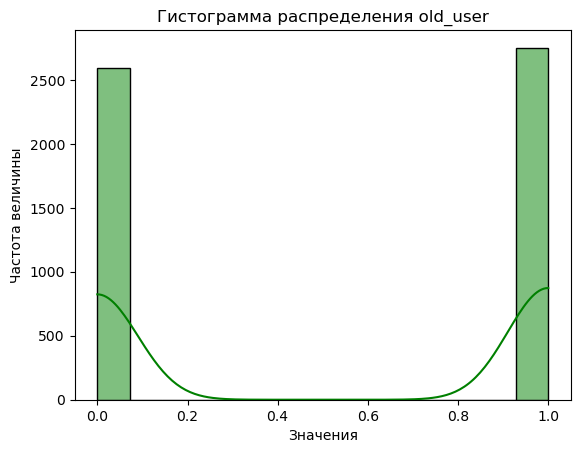

In [4]:
for i in df.columns:
    sns.histplot(df[i], kde=True, color = 'green')  
    plt.title(f"Гистограмма распределения {i}")
    plt.xlabel("Значения")
    plt.ylabel("Частота величины")
    plt.show()


Исходя из гистограммы распределения переменной LoanSum, можно сделать вывод, что распределение не является нормальным, так как оно сильно скошено вправо. Это смещение может повлиять на статистические тесты и модели, которые предполагают нормальное распределение данных(например, t-тест или ANOVA). В результате в дальнейшем нам потребуется преобразовать данные, чтобы выполнить необходимые эконометрические предпосылки.
Распределение срока займа также не следует нормальному закону. На гистограмме присутствуют пики, что может свидетельствовать о определенных предпочтениях сроков займа у заемщиков. Например, может быть больше краткосрочных займов с определенным сроком.
Гистограмма ПДН подтверждает наше предположение о выбросах, причем, значения выбросов крайне высокие, следовательно придётся очищать данные от подобных наблюдений.

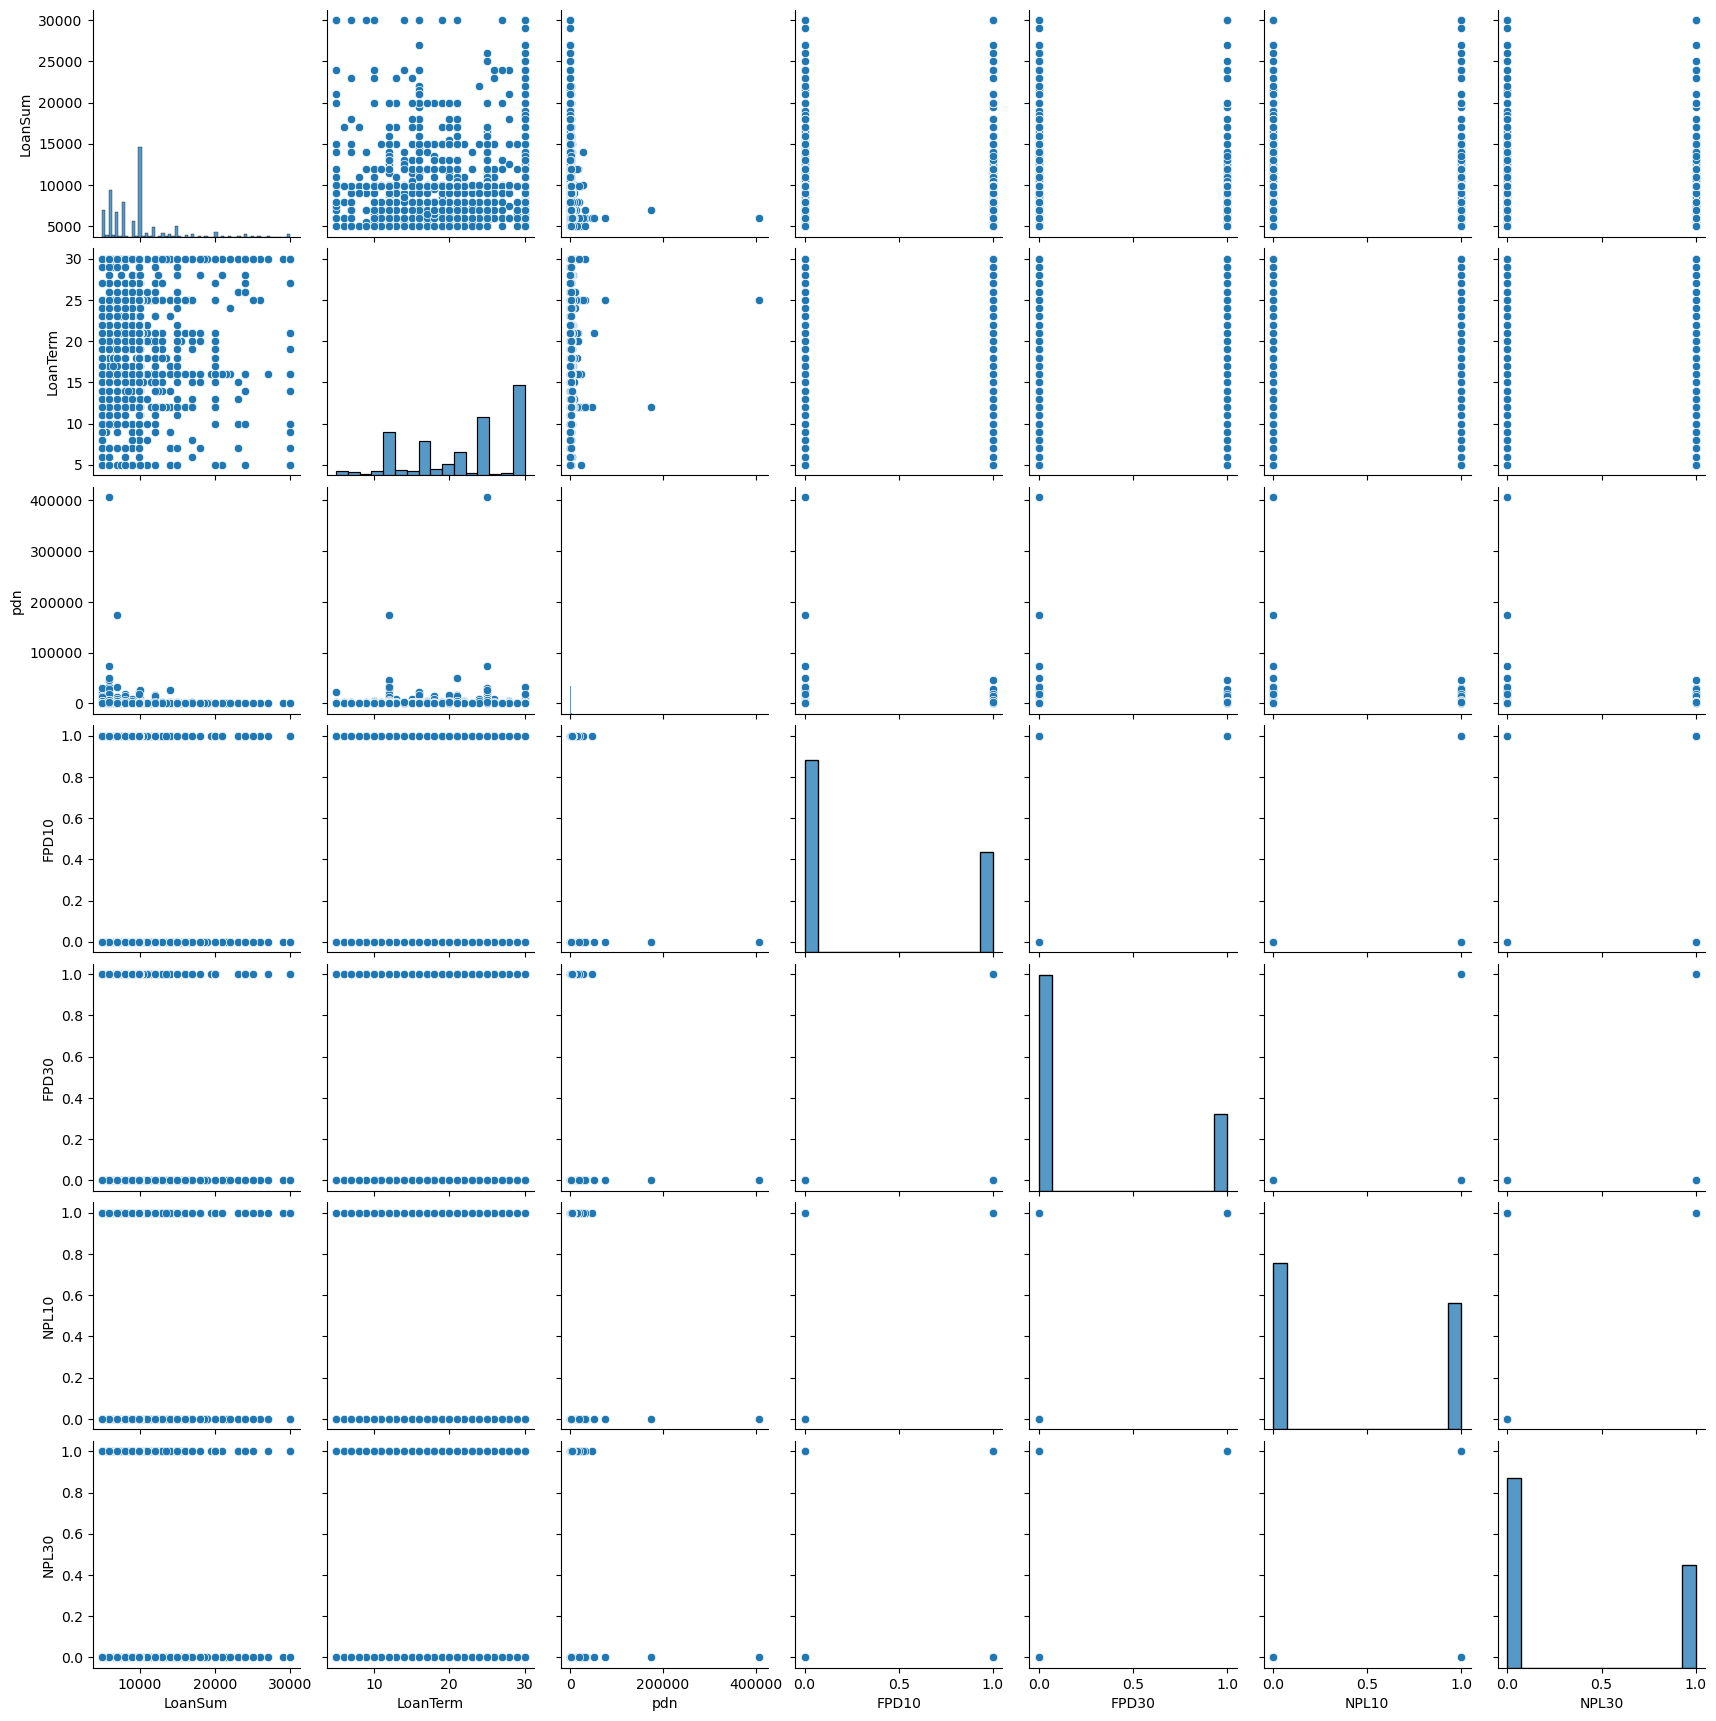

In [6]:
sns.pairplot(df[columns])

Наконец, исходя из графиков, видно, что в данных присутствуют значительные выбросы, которые однозначно окажут негативное влияние на дальнейший ход анализа. Ввиду этого, на этапе препроцессинга мы постараемся исправить ситуацию посредством преобразований или очистки данных. 